In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import qiskit
from qiskit import IBMQ, pulse, QuantumCircuit, execute, transpile, Aer, assemble
from qiskit.pulse import library, Schedule, Play, ShiftPhase, DriveChannel
from qiskit.pulse.macros import measure
from qiskit.pulse.schedule import ParameterizedSchedule
from qiskit.ignis.characterization import update_u_gates, get_single_q_pulse
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

import qiskit.ignis.verification.randomized_benchmarking as rb

In [ ]:
IBMQ.load_account()
armonk_real = IBMQ.providers()[0].backends.ibmq_armonk
# ddepcopy the int map of backend
origin_inst_map = deepcopy(armonk_real.defaults().instruction_schedule_map)

In [63]:
# First create a fake backend for testing the code

#Import PulseSimulator and PulseSystemModel for pulse simulation, as well as the mock Armonk backend:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# backend for simulation
backend_sim = PulseSimulator(configuration=armonk_real.configuration(), )
backend_a = Aer.get_backend('qasm_simulator')
# Mock Armonk backend
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk
armonk_backend = FakeArmonk()
armonk_backend.configuration = armonk_real.configuration
armonk_backend.properties = armonk_real.properties
armonk_backend.defaults = armonk_real.defaults
#Manual insertion of Hamiltonian parameters:
#Caution: Hamiltonian parameters are required for FAKE BACKEND
# set the drive strength
# getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = 63455017.85
# armonk_backend.defaults().instruction_schedule_map.get('x', 0)
# set the qubit frequency
# Caution: the frequency of the qubit of the real backend, look up the frequency in the spec in IBMQ
# freq_est = 4.97e9
# armonk_backend.defaults().qubit_freq_est = [freq_est]
# getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

#Generate model from backend:
# armonk_model = PulseSystemModel(hamiltonian=)
# getattr(armonk_real.configuration(), 'hamiltonian')['vars']['omegad0']
# armonk_model.
# armonk_real.configuration().qubit_freq_est
armonk_model.calculate_channel_frequencies()

OrderedDict([('D0', 4974450992.607534)])

In [64]:
armonk_backend.configuration().qubit_freq_est

AttributeError: Attribute qubit_freq_est is not defined

In [52]:
# All the basic gates in the backend
# armonk_backend.defaults().instruction_schedule_map.instructions

In [ ]:
# 3.Run Rabi experiments and fit 𝜋-pulse amplitude
#Next, we run a Rabi experiments generated using Ignis on the simulator using the system model generated from the Armonk backend.

#First, construct Rabi experiment schedules:
# qubit list
qubit = 0

#Number of shots
num_shots = 2048

# drive shape parameters
# Important warning!
# You must check that how long the duration of the device be used can support.
# ex. the last few terms in np.arrange(64, 4160, 64) is not support by ibmq_bogota

drive_duration = np.arange(64, 4160, 64) # np.arange(96, 1024, 32) for ibmq_bogota
drive_sigma = np.arange(8, 520, 8) # np.arange(12, 128, 4) for ibmq_bogota
# print(drive_sigma)
# print(drive_duration)

# drive amplitudes to be used
num_exps = 13
drive_amps = np.linspace(0.3, 1.0, num_exps)
# print(drive_amps)

# list of drive channels
drive_channels = [DriveChannel(0)]

In [ ]:
rabi_schedules=[]
for amp in drive_amps:
    for i in range(len(drive_duration)):
        sched = pulse.Schedule(name='Rabi amp={}, duration={}'.format(amp, drive_duration[i]))
        sched += pulse.Play(library.Gaussian(int(drive_duration[i]),
                                             amp,int(drive_sigma[i])).get_waveform(),
                            pulse.DriveChannel(qubit))
        sched += measure([qubit], armonk_backend) << sched.duration
        rabi_schedules.append(sched)
# rabi_schedules[0].draw(plot_range=[0,512])

# Assemble the qobj for job submission.
# When assembling pulse schedules to be used with the pulse simulator, pass the PulseSimulator as the backend.

rabi_qobj = assemble(rabi_schedules,
                 backend=backend_sim,
                 meas_level=1,
                 meas_return='avg',
                 shots=num_shots)

In [ ]:
# Run the simulation on fake_armonk:
sim_result = backend_sim.run(rabi_qobj, armonk_model).result()

In [ ]:
cnt_sched = 0
response  = np.zeros([len(drive_amps), len(drive_duration)])
for i in range(len(drive_amps)):
    resp_Amp = np.zeros(len(drive_duration), dtype=complex)
    for j in range(len(drive_duration)):
        resp_Amp[j] = sim_result.get_memory(cnt_sched)[qubit]
        cnt_sched = cnt_sched + 1
    resp_Amp = resp_Amp-np.mean(resp_Amp)
    response[i] = np.real(resp_Amp)

# print(len(response))
# print(len(response))
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('Rabi Oscillation', fontsize='22')
plt.plot(drive_duration, response[0],'-*')
plt.xlabel('Pulse Duration (dt of the backend)', fontsize='20')
plt.ylabel('Population (without scaling)', fontsize='20')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.show()

In [ ]:
# Fitting the rabi oscillation date
from scipy.optimize import curve_fit
def cos_fit_func(x, A,B, w, phi):
    return B + A * np.cos(2*np.pi*x*w + phi)

def fit_Freq(x, y, xMax):
    """  [default]   xMax = 2.5

    """
    y2 = 1/np.abs(np.max(y)) * np.real(y)
    x2 = np.linspace(0, xMax, len(x))
    #plt.plot(x2, y2,'-*')

    fitparams, conv = curve_fit(cos_fit_func, x2, y2, [ 1,  0,  1, 0])
    a0, b0, w0, phi0 = fitparams
    print(' ***************** ')
    print(a0, b0, w0, phi0)

    # plt.figure(figsize=(8, 6), facecolor='w')
    plt.title('Rabi Oscillation with fitting curve', fontsize='22')
    plt.plot(x2,cos_fit_func(x2, *fitparams),'.-',x2, y2,'-*')
    plt.xlabel('Pulse Duration (with scaling)', fontsize='20')
    plt.ylabel('Population (with scaling)', fontsize='20')
    plt.xticks(fontsize='14')
    plt.yticks(fontsize='14')
    # plt.show()

    # --------- rescaling back to the original unit  ------- #
    dT1 = x[1]   - x[0]
    dx2 = x2[1] - x2[0]
    Freq = w0 * (dx2/dT1)
    print(dx2, dT1, dx2/dT1, w0, Freq)

    return a0, b0, w0, phi0, Freq

# Get the 1st fine tune guess & fitting

In [ ]:
xMax = 1.5
response0 =  response[0] - np.mean( response[0] )
plt.figure(figsize=(8, 6), facecolor='w')
a0, b0, w0, phi0, Freq = fit_Freq(drive_duration, response0, xMax)

fparm_List = [np.array([a0, b0, w0, phi0])]
Amp_List   = [drive_amps[0]]
w0_List     = [w0]
Freq_List   = [Freq]
xMax_List  = [xMax]

#  More schedules:  changing both Amplitude & durations

In [ ]:
# plot all rabi oscillation for first half
Look_AR = np.arange(1, 6)
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('Rabi Oscillation for different driving amplitude', fontsize='22')
for cnt in Look_AR:
    resp_Amp = response[cnt]
    resp_Amp = resp_Amp - np.mean(resp_Amp)
    amp         = drive_amps[cnt]
    xMax_scal = xMax_List[-1] * (amp/Amp_List[-1])     #  estimated scaled  xMax
    print('amp={}, xMax_scale={}'.format(amp, xMax_scal))
    #print(resp_Amp)

    plt.plot(drive_duration,np.real(resp_Amp),'-*')
    plt.xlabel('Pulse Duration (without scaling)', fontsize='20')
    plt.ylabel('Population (without scaling)', fontsize='20')
    plt.xticks(fontsize='14')
    plt.yticks(fontsize='14')

plt.legend(drive_amps[Look_AR])
plt.show()

In [ ]:
# plot all rabi oscillation for last half
Look_AR = np.arange(6, len(drive_amps))
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('Rabi Oscillation for different driving amplitude', fontsize='22')
for cnt in Look_AR:
    resp_Amp = response[cnt]
    resp_Amp = resp_Amp - np.mean(resp_Amp)
    amp         = drive_amps[cnt]
    xMax_scal = xMax_List[-1] * (amp/Amp_List[-1])     #  estimated scaled  xMax
    print('amp={}, xMax_scale={}'.format(amp, xMax_scal))
    #print(resp_Amp)

    plt.plot(drive_duration,np.real(resp_Amp),'-*')
    plt.xlabel('Pulse Duration (without scaling)', fontsize='20')
    plt.ylabel('Population (without scaling)', fontsize='20')
    plt.xticks(fontsize='14')
    plt.yticks(fontsize='14')

plt.legend(drive_amps[Look_AR])
plt.show()

In [ ]:
# fitting data for each rabi oscillation

for cnt in np.arange(1, len(drive_amps)):
    plt.figure(figsize=(8, 6), facecolor='w')
    resp_Amp = response[cnt]
    resp_Amp = resp_Amp - np.mean(resp_Amp)
    amp         = drive_amps[cnt]
    xMax_scal = xMax_List[-1] * (amp/Amp_List[-1])     #  estimated scaled  xMax
    str = 'amp={}, xMax_scale={:.2f}'.format(amp, xMax_scal)
    print(str)

    a0, b0, w0, phi0, Freq = fit_Freq(drive_duration, resp_Amp, xMax_scal)
    plt.legend([str], loc = 'upper right')
    plt.show()


    Amp_List.append(amp)
    w0_List.append(w0)
    Freq_List.append(Freq)
    xMax_List.append(xMax_scal)
    fparm_List.append(np.array([a0, b0, w0, phi0]))

In [ ]:
fit_coef   = np.polyfit(Amp_List, Freq_List, 1)
Rabi_linear  = np.poly1d(fit_coef)
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('Check Linearity', fontsize='22')
plt.plot(Amp_List, Freq_List,'yo', Amp_List, Rabi_linear(Amp_List), '--k')
plt.xlabel(' pulse amplitude', fontsize='20')
plt.ylabel(' fitting Rabbi frequency', fontsize='20')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
# plt.savefig('linearity.jpg', dpi=150)
plt.show()

Randomized Benchmarking

Create function to modify the inst_map

In [6]:
# function for modify the parameters
def tune_param(params, c1):
    """  (eg) C1 = 2 = ratio to extend duration & sigma
     X pulse ==>
        inst.pulse = Drag(duration=640, amp=(0.6472753752719002+0j), sigma=160, beta=-4.631873857015726)
        inst.pulse.parameters  = {'duration': 640, 'amp': (0.6472753752719002+0j), 'sigma': 160, 'beta': -4.631873857015726}
    """
    params['sigma'] = params['sigma'] * c1
    params['amp']   = params['amp'] / c1
    params['duration'] = params['duration'] * c1
    #print(params)
    return params

In [7]:
def update_x_gates(drag_params, pi2_pulse_schedules=None,
                   qubits=None, inst_map=None, drives=None):
    """Update the cmd_def with new single qubit gate values
    Will update x
    Args:
        drag_params (list): list of drag params
        pi2_pulse_schedules (list): list of new pi/2 gate as a pulse schedule
                             will use the drag_params if this is None.
        qubits (list): list of qubits to update
        inst_map (InstructionScheduleMap): InstructionScheduleMap providing
            circuit instruction to schedule definitions.
        drives (list): List of drive chs
    """
    for qubit in qubits:

        drive_ch = drives[qubit]

        if pi2_pulse_schedules is None:
            x90_pulse = library.drag(**drag_params[qubit])
            x90_sched = Schedule()
            x90_sched += Play(x90_pulse, drive_ch).shift(0)
        else:
            x90_sched = pi2_pulse_schedules[qubit]

        pulse_dur = x90_sched.duration

        # find channel dependency for x

        _x_group = (drive_ch, )

        # add commands to schedule
        # x
        sched_components = [x90_sched]
        schedule1 = ParameterizedSchedule(*sched_components,
                                          parameters=None, name='x_%d' % qubit)



        inst_map.add('x', qubits=qubit, schedule=schedule1)

In [8]:
def mod_inst_map(inst_map_, c, qubit_):
    inst_map_copy = deepcopy(inst_map_)
    x_sched_ = inst_map_copy.get('x', qubit_)
    u2_sched_ = inst_map_copy.get('u2', qubit_, P0=1, P1=1)
    u3_sched_ = inst_map_copy.get('u3', qubit_, P0=1, P1=1, P2=1)
    print('origin parameters')
    # print(x_sched_)
    # print(u2_sched_)
    # print(u3_sched_)
    inst_u3_ = u3_sched_.instructions[1][1]
    # print(inst_u3_)
    x_params_ = x_sched_.instructions[0][1].pulse.parameters
    origin_params_ = inst_u3_.pulse.parameters
    print(x_params_)
    print(origin_params_)
    # modify the parameters
    mod_x_params_ = tune_param(x_params_, c)
    mod_params_ = tune_param(origin_params_, c)
    print('modify parameters')
    print(mod_x_params_)
    print(mod_params_)
    dri_channel = []
    for q_i in qubit_:
        dri_channel.append(pulse.DriveChannel(q_i))
    update_x_gates([mod_x_params_], None, qubit_, inst_map_copy, dri_channel)
    update_u_gates([mod_params_], None, qubit_, inst_map_copy, dri_channel)
    get_single_q_pulse(inst_map_copy, [0])

    return inst_map_copy

In [10]:
# get the mapping
origin_inst_map.get('u2', qubits=[0], P0=1, P1=1)


Schedule((0, ShiftPhase(-1.0, DriveChannel(0))), (0, Play(Drag(duration=640, amp=(0.011100704072929268+0.31629613734202117j), sigma=160, beta=-4.252736887891531), DriveChannel(0))), (640, ShiftPhase(-1.0, DriveChannel(0))), name="u2")

In [16]:
# modify backend
new_inst_map = mod_inst_map(origin_inst_map, 3, [0])
armonk_real.defaults().instruction_schedule_map = new_inst_map

origin parameters
{'duration': 640, 'amp': (0.6509104280108182+0j), 'sigma': 160, 'beta': -4.597931138218261}
{'duration': 640, 'amp': (0.31629613734202117-0.011100704072929271j), 'sigma': 160, 'beta': -4.252736887891531}
modify parameters
{'duration': 1920, 'amp': (0.21697014267027273+0j), 'sigma': 480, 'beta': -4.597931138218261}
{'duration': 1920, 'amp': (0.10543204578067372-0.003700234690976424j), 'sigma': 480, 'beta': -4.252736887891531}


In [ ]:
# create a device backend noise model
# noise_model = NoiseModel.from_backend(armonk_real)
# print(noise_model)

In [21]:
#Number of qubits
nQ = 1

#Number of seeds (random sequences)
nseeds = 10

#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,10)

#2Q RB on Q0,Q2 and 1Q RB on Q1
rb_pattern = [[0]]

#Do three times as any 1Q Cliffords
length_multiplier = 1

rb_opts = {'length_vector': nCliffs,
           'nseeds': nseeds,
           'rb_pattern': rb_pattern,
           'length_multiplier': length_multiplier,
           'group_gates': 'Clifford'}

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

c_list = [1, 2, 3]
shots = 20
transpiled_circs_list = []
ydata = []
for ci in c_list:
    print('Cj = ', ci)
    temp_inst_map = mod_inst_map(origin_inst_map, ci, [0])
    armonk_real.defaults().instruction_schedule_map = temp_inst_map

    # backend_sim.defaults().instruction_schedule_map = temp_inst_map

    transpiled_circs_list = []
    ydata_temp = []
    rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
    for rb_seed, rb_circ_seed in enumerate(rb_circs):
        print('Compiling seed %d'%rb_seed)
        new_rb_circ_seed = transpile(rb_circ_seed,
                                     armonk_real,
                                     initial_layout=[0])
        for i in range(nseeds):
            transpiled_circs_list.append(new_rb_circ_seed[i])
        print('Simulating seed %d'%rb_seed)
        rb_sceldule = qiskit.schedule(new_rb_circ_seed,
                                      armonk_real,
                                      meas_map=armonk_real.configuration().meas_map,
                                      inst_map=armonk_real.defaults().instruction_schedule_map)
        rb_qobj = assemble(rb_sceldule,
                           backend=backend_sim,
                           meas_level=2,
                           rep_time=1,
                           meas_return='avg',
                           shots=shots)
        sim_result = backend_sim.run(rb_qobj,
                                     system_model=armonk_model,
                                     backend_options={'max_parallel_experiments': 0}
                                     ).result()
        # job = execute(rb_sceldule, backend_sim, system_model=armonk_model, shots=shots)
        # Add data to the fitter
        rb_fit.add_data(sim_result)
        print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))
        ydata_temp.append(rb_fit.ydata[0]['mean'])
    ydata.append(ydata_temp)

Cj =  1
origin parameters
{'duration': 640, 'amp': (0.6509104280108182+0j), 'sigma': 160, 'beta': -4.597931138218261}
{'duration': 640, 'amp': (0.31629613734202117-0.011100704072929271j), 'sigma': 160, 'beta': -4.252736887891531}
modify parameters
{'duration': 640, 'amp': (0.6509104280108182+0j), 'sigma': 160, 'beta': -4.597931138218261}
{'duration': 640, 'amp': (0.31629613734202117-0.011100704072929271j), 'sigma': 160, 'beta': -4.252736887891531}
Compiling seed 0
Simulating seed 0
After seed 0, alpha: 1.000000, EPC: 0.000000
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 1.000000, EPC: 0.000000
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 1.000000, EPC: 0.000000
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 1.000000, EPC: 0.000000
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 1.000000, EPC: 0.000000
Compiling seed 5
Simulating seed 5
After seed 5, alpha: 1.000000, EPC: 0.000000
Compiling seed 6
Simulating seed 6
After seed 6, alpha: 1.000000, EP

In [ ]:
job = execute(rb_sceldule, backend_sim, system_model=armonk_model, shots=shots)
result = job.result()

In [ ]:
backend_sim.defaults().instruction_schedule_map.instructions

In [18]:
print('c = ', c_list)

def gamma_j(c_list_):
    gamma_list = []
    for j in range(len(c_list_)):
        gamma_temp = 1
        for m_a in range(j):
            gamma_temp *= c_list_[m_a]/(c_list_[j]-c_list_[m_a])
        for m_b in range(len(c_list_)-j-1):
            gamma_temp *= c_list_[m_b+j+1]/(c_list_[j]-c_list_[m_b+j+1])
        gamma_list.append(gamma_temp)
    # if len(c_list_)%2==0:
        # gamma_list *= (-1)
    return gamma_list
gamma_list = gamma_j(c_list)
print(gamma_list)

print('check constraints')
print('j from 0 to n = ', len(c_list)-1)
print('Summation of gamma_j = ',sum(gamma_list))
rc = 0
for k in range(len(c_list)-1):
    for i in range(len(gamma_list)):
        rc += c_list[i]**(k+1)*gamma_list[i]
print('Summation of gamma_j * c_j**(from 1 to n) = ', rc)

c =  [1, 2, 3]
[3.0, -3.0, 1.0]
check constraints
j from 0 to n =  2
Summation of gamma_j =  1.0
Summation of gamma_j * c_j**(from 1 to n) =  0.0


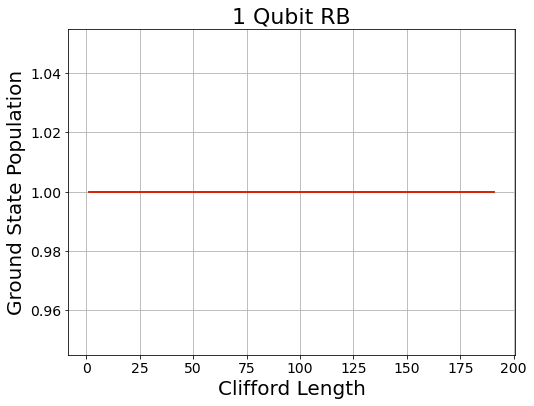

In [19]:
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('%d Qubit RB'%(nQ), fontsize=22)
plt.xlabel('Clifford Length', fontsize=20)
plt.ylabel('Ground State Population', fontsize=20)
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.grid()
for i in range(len(c_list)):
    plt.plot(xdata[0], ydata[i][2])
# plt.plot(xdata[0], 1.5*ydata[0][2]-0.5*ydata[1][2], 'r')
# plt.plot(xdata[0], 3*ydata[0][1]-3*ydata[1][1]+ydata[2][1])
plt.savefig('Richardson_RB_result_2.jpg', dpi=150)
plt.show()
